<a href="https://colab.research.google.com/github/thomasdhille/bankruptcy/blob/main/Bankruptcy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bankruptcy Prediction

Data source: (https://www.sciencedirect.com/science/article/pii/S0377221716000412)
> _Financial ratios and corporate governance indicators in bankruptcy prediction: A comprehensive study_, <br>
> Deron Liang, Chia-Chi Lu, Chih-Fong Tsai, Guan-An Shih <br>
> European Journal of Operational Research

I implement a simplified non-time-dependent modification of an RNN model to predict __cell-death__ to predict __bankruptcy__ based on some indicators proposed by the aforementioned authors. 

The authors implement traditional ML techniques and a 1 layer DNN (which is not optimal). The simple DNN models below computed on a single GPU outperform the traditional methods implemented in that paper.

__Notes:__

- Accuracy is used here simply as a _performance metric_, but (in my opinion) meaningless as an _evaluation metric_ as the distribution of the data is highly skewed. More concretely, the data is distributed 97/3, so a model predicting _always_ the first category would have already an accuracy exceeding 90%.
  - __Warning:__ the paper above considers accuracy as an _evaluation metric_. 

  - The best classifier in the above mentioned paper, namely SVM,  achieves in the study a Type I (False Positive) error of at least  16% and Type II (False Negative) error of at least  18%, depending on the feature selection. This is already achieved by the __baseline DNN model__ below.

- The simple DNN below is (very roughly) tuned with the objective of maximizing the __F1 score__ and as such minimizing false positives (i.e., predicting a company is bankrupt when it is not) and false negatives (i.e. predicting a company is not bankrupt when it is) jointly. Of course this could be tuned finer.

- I run three DNN models below:
  - __Baseline:__ adjusting the skewness of the data with weights.
  - __Naive Data Augmentation:__ we augment the training set by randomly oversampling the minority category.
  - __SMOTE:__ we oversample the minority category in the training set with synthetic samples by selecting the nearest neighbors and perturbing them randomly along the line connecting the selected points. This helps to avoid overfitting.

- __Feature Importance:__ __after our conversation__ regarding the interpretation of Deep Learning models I thought about a possibility of interpreting and extrapolating the __importance of features__ of the result. Deep Learning models like the one below construct a (smooth) function 
$$
\mathbb P : \{\text{Feature Space} \} \longrightarrow [0,1]
$$
which in the case at hand can be interpreted in terms of probabilities, e.g. if ${\bf x} \in \{\text{Feature Space} \}$, then $\mathbb P(\bf x)$ is tantamount to the probability of the company corresponding to $\bf x$ being bankrupt or not. Moreover, in the example below the feature space is a subspace $\{\text{Feature Space} \} \subseteq \mathbb R^{49}$. Thus, one --first order-- method to extrapolate the importance of the features is to sample $\displaystyle{ \frac{\partial \mathbb P}{\partial x_1}}, \dots, \frac{\partial \mathbb P}{\partial x_{49}}$ and order these by magnitude. An improvement to this is simply to look a second order impacts.



__Comments:__

- Using (essentially) stationary data points to predict a dynamic occurence (like bankruptcy) seems far from optimal. However, this seems to be norm (e.g. https://arxiv.org/pdf/2002.11705.pdf considers granular credit data)
- Bankruptcy seems to me a dynamic time-dependent problem for which there exists a point of no return and not a problem that should be modeled from the point of view of stationary indicators. Thus, the object should be aimed towards estimating the time-dependent movement of these indicators. Of course, provided such data is feasible to gather.

- The stationarity of the data is the likeliest reason all of the models -- including the one below -- fall below any reasonable prediction. However, since the models __do not completely fail__, it is reasonable to believe that the data gathered does contribute to the prediction of bankruptcy. However, these __datapoints should be in the form of time-series__ for this to work. 

__Results:__ (see Feature Importance Section for details)

- F1 scores:
   - Baseline model: 0.24
   - Naive Data Augmentation model: 0.26
   - SMOTE model: 0.33
   - In the abovementioned paper all < 0.21

- Precision scores:
   - Baseline model: 0.14
   - Naive Data Augmentation model: 0.15
   - SMOTE model: 0.22
   - In the abovementioned paper: no precision, just accuracy.

- Feature importance: all three models show very similar feature importance graphs: 

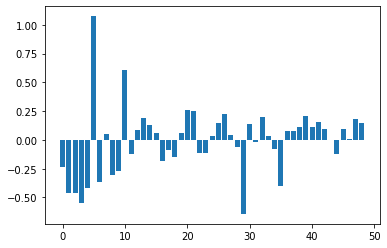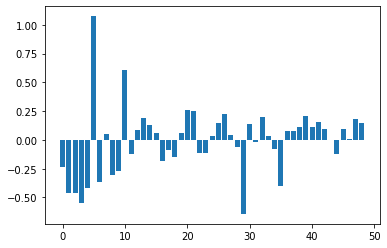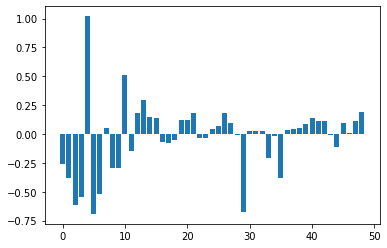

The top 5 features determining all three models the most are:
- Debt ratio %, 
- Net worth/Assets,
- Persistent EPS in the Last Four Seasons,
- ROA(B) before interest and depreciation after tax, 
- Cash/Total Assets





In [ ]:
import os
import tempfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler, SMOTE

import sklearn
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, layers, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
!pip install tensorflow-addons
import tensorflow_addons as tfa

!pip install keras-tuner
from kerastuner.tuners import BayesianOptimization
from kerastuner import Objective

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.5 MB/s eta 0:00:00


<ipython-input-1-a3b7ecdaec50>:26: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [ ]:
df = pd.read_csv('data.csv')

## Features, Dataset and Datatypes

The dataset consists of 95 features and and 6819 observations. Each observation labeled 0 or 1

In [ ]:
# Length of dataset

df.shape

(6819, 96)

In [ ]:
# Shape of dataframe

df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [ ]:
# Enumeration and description of feature

for i, column in enumerate(df.columns[1:], start=2):
    print(f"{i-1}. {column}")

1.  ROA(C) before interest and depreciation before interest
2.  ROA(A) before interest and % after tax
3.  ROA(B) before interest and depreciation after tax
4.  Operating Gross Margin
5.  Realized Sales Gross Margin
6.  Operating Profit Rate
7.  Pre-tax net Interest Rate
8.  After-tax net Interest Rate
9.  Non-industry income and expenditure/revenue
10.  Continuous interest rate (after tax)
11.  Operating Expense Rate
12.  Research and development expense rate
13.  Cash flow rate
14.  Interest-bearing debt interest rate
15.  Tax rate (A)
16.  Net Value Per Share (B)
17.  Net Value Per Share (A)
18.  Net Value Per Share (C)
19.  Persistent EPS in the Last Four Seasons
20.  Cash Flow Per Share
21.  Revenue Per Share (Yuan ¥)
22.  Operating Profit Per Share (Yuan ¥)
23.  Per Share Net profit before tax (Yuan ¥)
24.  Realized Sales Gross Profit Growth Rate
25.  Operating Profit Growth Rate
26.  After-tax Net Profit Growth Rate
27.  Regular Net Profit Growth Rate
28.  Continuous Net Profit 

In [ ]:
# Summary of basic statistical properties

df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [ ]:
# Datatypes of values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

## Distribution of Dataset

### Skewness of Labels

Main difficulty is the heavy asymmetry in the distribution of the observables.

In [ ]:
# get a count of how many 0s and how many 1s are in the Bankruptcy column

counts = df['Bankrupt?'].value_counts()

# divide each count by the total number of rows in the column to get the percentage
percentages = counts / len(df) * 100

# create a new DataFrame to display the counts and percentages
data = {'Count': counts, 'Percentage': percentages}
df_counts = pd.DataFrame(data)

# print the DataFrame
display(df_counts)

# For later use define
neg, pos = df_counts['Count'][0], df_counts['Count'][1]
total = neg + pos

,Count,Percentage
0,6599,96.77372
1,220,3.22628


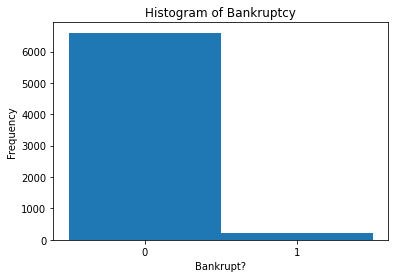

In [ ]:
# plot a histogram of the Bankruptcy column
df['Bankrupt?'].hist(bins=2)

# set the x-axis labels to the categories of the binary variable
plt.xticks([0.25, 0.75], labels=['0', '1'])

# add labels and a title to the plot
plt.xlabel('Bankrupt?')
plt.ylabel('Frequency')
plt.title('Histogram of Bankruptcy')
plt.grid(False)

# display the plot
plt.show()

### Correlation of Features with Bankruptcy

Not necessary for Neural Networks, but we select features that highly correlate with Bankruptcy. Below a sample of top 10 features with this property and after that we select those that are negligible in correlation up to 0.05 (this is an arbitrary baseline, but their effect in bankruptcy is less that 1/7 compared to that of the most correlated features).

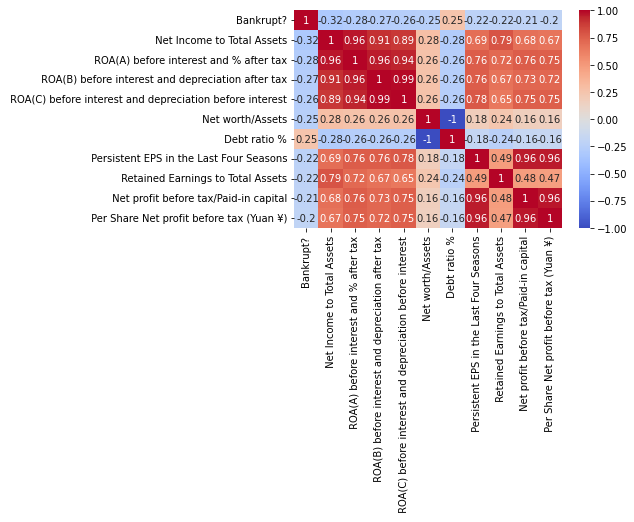

In [ ]:
# compute the correlation matrix
corr_matrix = df.corr()

# extract the top 10 features with highest absolute correlation to 'Bankrupt?'
top_features = corr_matrix.abs().nlargest(11, 'Bankrupt?')['Bankrupt?'].index[1:]

# create a sub-DataFrame with the 'Bankrupt?' column and the top 10 features
top_features = df[['Bankrupt?'] + list(top_features)]

# compute the correlation matrix of the top 10 features
corr_top_features = top_features.corr()

# plot the correlation matrix using a heatmap
sns.heatmap(corr_top_features, cmap='coolwarm', annot=True)

# display the plot
plt.show()

In [ ]:
# compute the correlation of 'Bankrupt?' with every other column
corr_with_bankrupt = df.corrwith(df['Bankrupt?'])

# create a DataFrame with the correlation coefficients and column names
corr_df = pd.DataFrame({'correlation': corr_with_bankrupt})

# drop the 'Bankrupt?' row and the 'abs_correlation' column
corr_df = corr_df.drop(['Bankrupt?'])
corr_df['abs_correlation'] = corr_df['correlation'].abs()
corr_df = corr_df.sort_values('abs_correlation', ascending=False)
corr_df = corr_df.drop(['abs_correlation'], axis=1)

# display the resulting correlation DataFrame
corr_df 


,correlation
Net Income to Total Assets,-0.315457
ROA(A) before interest and % after tax,-0.282941
ROA(B) before interest and depreciation after tax,-0.273051
ROA(C) before interest and depreciation before interest,-0.260807
Net worth/Assets,-0.250161
...,...
Long-term Liability to Current Assets,0.000778
Cash Flow to Sales,0.000479
Realized Sales Gross Profit Growth Rate,-0.000458
Operating Profit Rate,-0.000230


In [ ]:
# drop rows with absolute correlation less than 0.05 (strictly speaking we need to get rid of NIF)
corr_df = corr_df[abs(corr_df['correlation']) >= 0.05].dropna()
corr_df

print(list(corr_df.index))

# updating df with relevant features
columns = ['Bankrupt?']+list(corr_df.index)
df = df.loc[:, columns]

df.head()

[' Net Income to Total Assets', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' ROA(C) before interest and depreciation before interest', ' Net worth/Assets', ' Debt ratio %', ' Persistent EPS in the Last Four Seasons', ' Retained Earnings to Total Assets', ' Net profit before tax/Paid-in capital', ' Per Share Net profit before tax (Yuan ¥)', ' Current Liability to Assets', ' Working Capital to Total Assets', " Net Income to Stockholder's Equity", ' Borrowing dependency', ' Current Liability to Current Assets', ' Liability to Equity', ' Net Value Per Share (A)', ' Net Value Per Share (B)', ' Net Value Per Share (C)', ' Current Liability to Equity', ' Current Liabilities/Equity', ' Working Capital/Equity', ' Operating Profit Per Share (Yuan ¥)', ' Operating profit/Paid-in capital', ' Liability-Assets Flag', ' Total expense/Assets', ' Equity to Long-term Liability', ' CFO to Assets', ' Tax rate (A)', ' Cash/Total Assets', ' Gross Profit 

,Bankrupt?,Net Income to Total Assets,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,ROA(C) before interest and depreciation before interest,Net worth/Assets,Debt ratio %,Persistent EPS in the Last Four Seasons,Retained Earnings to Total Assets,Net profit before tax/Paid-in capital,...,Inventory and accounts receivable/Net value,Fixed Assets Turnover Frequency,Cash flow rate,Cash Flow to Total Assets,Contingent liabilities/Net worth,Total Asset Turnover,Fixed Assets to Assets,Net Value Growth Rate,Cash Flow to Equity,Cash Reinvestment %
0,1,0.716845,0.424389,0.405750,0.370594,0.792424,0.207576,0.169141,0.903225,0.137757,...,0.398036,1.165007e-04,0.458143,0.637555,0.006479,0.086957,0.424206,0.000327,0.312905,0.363725
1,1,0.795297,0.538214,0.516730,0.464291,0.828824,0.171176,0.208944,0.931065,0.168962,...,0.397725,7.190000e+08,0.461867,0.641100,0.005835,0.064468,0.468828,0.000443,0.314163,0.376709
2,1,0.774670,0.499019,0.472295,0.426071,0.792484,0.207516,0.180581,0.909903,0.148036,...,0.406580,2.650000e+09,0.458521,0.642765,0.006562,0.014993,0.276179,0.000396,0.314515,0.368913
3,1,0.739555,0.451265,0.457733,0.399844,0.848535,0.151465,0.193722,0.906902,0.147561,...,0.397925,9.150000e+09,0.465705,0.579039,0.005366,0.089955,0.559144,0.000382,0.302382,0.384077
4,1,0.795016,0.538432,0.522298,0.465022,0.893491,0.106509,0.212537,0.913850,0.167461,...,0.400079,2.935211e-04,0.462746,0.622374,0.006624,0.175412,0.309555,0.000439,0.311567,0.379690


### Preparing the Data

In [ ]:
### Splitting of Data

# shuffle the rows of the DataFrame
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# split the DataFrame into training and dev sets, ensuring that the proportion of 0s and 1s is the same in both sets
train_full_df, test_full_df = train_test_split(df_shuffled, test_size=0.2, stratify=df_shuffled['Bankrupt?'], random_state=42)

# calculate the proportion of 0s and 1s in the training and train sets
train_counts = train_full_df['Bankrupt?'].value_counts()
test_counts = test_full_df['Bankrupt?'].value_counts()
train_proportions = train_counts / len(train_full_df)
test_proportions = test_counts / len(test_full_df)

# print the proportions of 0s and 1s in the training and test sets
print('Training Set Proportions:\n', train_proportions)
print('Test Set Proportions:\n', test_proportions)

Training Set Proportions:
 0    0.967736
1    0.032264
Name: Bankrupt?, dtype: float64
Test Set Proportions:
 0    0.967742
1    0.032258
Name: Bankrupt?, dtype: float64


In [ ]:
# split the data into training, val and test sets

train_df, val_df = train_test_split(train_full_df, test_size=0.3, stratify=train_full_df['Bankrupt?'], random_state=42)
train_features, train_labels = train_df.drop('Bankrupt?',axis=1).values, train_df['Bankrupt?'].values
bool_train_labels = train_labels != 0
val_features, val_labels = val_df.drop('Bankrupt?',axis=1).values, val_df['Bankrupt?'].values
test_features, test_labels = test_full_df.drop('Bankrupt?',axis=1).values, test_full_df['Bankrupt?'].values

# calculate the proportion of 0s and 1s in val set
val_counts = val_df['Bankrupt?'].value_counts()
val_proportions = val_counts / len(val_features)


# print the proportions of 0s and 1s in the training and test sets
print('Val Set Proportions:\n', val_proportions)


Val Set Proportions:
 0    0.967624
1    0.032376
Name: Bankrupt?, dtype: float64


#### Baseline: Weight Adjustment

In [ ]:
# compute class weights
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',
                                                                classes = np.unique(train_labels),
                                                                y= train_labels)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.5166441136671177, 1: 15.520325203252032}

#### Method 1: Naive Data Augmentation

In [ ]:
# Data augmentation for training set

# Create random oversampler
oversampler = RandomOverSampler()

# Resample training data to balance classes
train_features_oversampler, train_labels_oversampler = oversampler.fit_resample(train_features, train_labels)

#### Method 2: SMOTE (Synthetic Over-Sampling)

In [ ]:
# Instantiate the SMOTE object
smote = SMOTE()

# Apply SMOTE to the training data
train_features_smote, train_labels_smote = smote.fit_resample(train_features, train_labels)

#### Feature Scaling

In [ ]:
# scale input features

scaler = MaxAbsScaler()
train_features = scaler.fit_transform(train_features)
train_features_oversampler = scaler.fit_transform(train_features_oversampler)
train_features_smote = scaler.fit_transform(train_features_smote)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Training_oversampler labels shape:', train_labels_oversampler.shape)
print('Training_smote labels shape:', train_labels_smote.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Training_oversampler features shape:', train_features_oversampler.shape)
print('Training_smote features shape:', train_features_smote.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (3818,)
Training_oversampler labels shape: (7390,)
Training_smote labels shape: (7390,)
Validation labels shape: (1637,)
Test labels shape: (1364,)
Training features shape: (3818, 49)
Training_oversampler features shape: (7390, 49)
Training_smote features shape: (7390, 49)
Validation features shape: (1637, 49)
Test features shape: (1364, 49)


# Model and Metrics

In this architecture, the METRICS list contains several Keras metrics objects that are used to evaluate the performance of the binary classification model:

- TruePositives: The number of true positive predictions.
- FalsePositives: The number of false positive predictions.
- TrueNegatives: The number of true negative predictions.
- FalseNegatives: The number of false negative predictions.
- BinaryAccuracy: The fraction of correctly classified samples, i.e., (TP + TN) / (TP + TN + FP + FN).
- Precision: The fraction of true positives among all positive predictions, i.e., TP / (TP + FP).
- Recall: The fraction of true positives among all actual positives, i.e., TP / (TP + FN).
- AUC: The area under the ROC curve, which is a measure of the model's ability to distinguish between positive and negative samples.
- F1: The harmonic mean of precision and recall
- AUC (with curve='PR'): The area under the precision-recall curve, which is another measure of the model's ability to distinguish between positive and negative samples.

The `build_model` function creates a Keras sequential model. It has several hidden layers with different numbers of units and dropout layers to prevent overfitting. The model starts with a dense layer with a number of units specified by the hyperparameter `units1`, which is a range of integers from 32 to 512 with a step of 32. The activation function used in this layer is `ReLU`. The `kernel_regularizer` argument is used to apply L2 regularization to the layer weights. A dropout layer is added after the first dense layer to randomly drop out a fraction of the input units during training, specified by the hyperparameter `dropout1`. 
The same pattern is repeated for the next two dense layers, with the number of units and dropout rate specified by hyperparameters `units2`, `dropout2`, `units3`, and `dropout3`.
Finally, the model ends with a dense layer with a single unit and a `sigmoid` activation function.

## Model Tuning

#### Baseline: Weight Adjustment

In [ ]:
# Define the metrics to track
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
      #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      tfa.metrics.F1Score(num_classes=1, threshold=0.5, name='f1_score')
]

def build_model(hp):
    model = Sequential()
    model.add(layers.Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.01),
                           input_shape=(train_features.shape[-1],)))
    model.add(layers.Dropout(rate=hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units2', min_value=32, max_value=512, step=32),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(rate=hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units3', min_value=32, max_value=512, step=32),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(rate=hp.Float('dropout3', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(units=1, activation='sigmoid'))

    # Define the optimizer and learning rate
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))

    # Compile the model with the specified metrics
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=METRICS,
                  )
    return model

# Define the hyperparameter search space
tuner = BayesianOptimization(
    build_model,
    objective=Objective('f1_score', direction='max'),
    max_trials=15,
    directory='tuner_results',
    project_name='bankruptcy',
    overwrite=True)


# Run the hyperparameter search
tuner.search(train_features, train_labels, validation_data=(val_features, val_labels), epochs=50, class_weight=class_weights_dict)

# Print the best hyperparameters and validation score
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(best_hps.values)

Trial 15 Complete [00h 00m 53s]
f1_score: 0.08494474738836288

Best f1_score So Far: 0.28532975912094116
Total elapsed time: 00h 19m 07s
Best hyperparameters:
{'units1': 32, 'dropout1': 0.0, 'units2': 160, 'dropout2': 0.30000000000000004, 'units3': 352, 'dropout3': 0.30000000000000004, 'learning_rate': 0.0003676909211752863}


#### Method 1: Naive Data Augmentation

In [ ]:
# Define the metrics to track
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
      #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      tfa.metrics.F1Score(num_classes=1, threshold=0.5, name='f1_score')
]

def build_model_oversampler(hp):
    model = Sequential()
    model.add(layers.Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.01),
                           input_shape=(train_features_oversampler.shape[-1],)))
    model.add(layers.Dropout(rate=hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units2', min_value=32, max_value=512, step=32),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(rate=hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(units=hp.Int('units3', min_value=32, max_value=512, step=32),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(rate=hp.Float('dropout3', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(units=1, activation='sigmoid'))

    # Define the optimizer and learning rate
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))

    # Compile the model with the specified metrics
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=METRICS,
                  )
    return model

# Define the hyperparameter search space
tuner_oversampler = BayesianOptimization(
    build_model_oversampler,
    objective=Objective('val_f1_score', direction='max'),
    max_trials=20,
    directory='tuner_results',
    project_name='bankruptcy',
    overwrite=True)


# Run the hyperparameter search
tuner_oversampler.search(train_features_oversampler, train_labels_oversampler, validation_data=(val_features, val_labels), epochs=50)

# Print the best hyperparameters and validation score
best_hps_oversampler = tuner_oversampler.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters for oversampler:")
print(best_hps_oversampler.values)

Trial 20 Complete [00h 01m 44s]
val_f1_score: 0.3867403268814087

Best val_f1_score So Far: 0.40449437499046326
Total elapsed time: 00h 32m 53s
Best hyperparameters for oversampler:
{'units1': 512, 'dropout1': 0.2, 'units2': 320, 'dropout2': 0.4, 'units3': 480, 'dropout3': 0.1, 'learning_rate': 0.0010813378402855828}


#### Method 2: SMOTE (Synthetic Over-Sampling)

In [ ]:
# Define the metrics to track
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
      #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      tfa.metrics.F1Score(num_classes=1, threshold=0.5, name='f1_score')
]

def build_model_smote(hp):
    model = Sequential()
    model.add(layers.Dense(units=hp.Int('units1', min_value=256, max_value=512, step=16),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.01),
                           input_shape=(train_features_smote.shape[-1],)))
    model.add(layers.Dropout(rate=hp.Float('dropout1', min_value=0.0, max_value=0.01, step=0.001)))
    model.add(layers.Dense(units=hp.Int('units2', min_value=64, max_value=256, step=16),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(rate=hp.Float('dropout2', min_value=0.0, max_value=0.01, step=0.001)))
    model.add(layers.Dense(units=hp.Int('units3', min_value=256, max_value=512, step=16),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(rate=hp.Float('dropout3', min_value=0.0, max_value=0.1, step=0.01)))
    model.add(layers.Dense(units=1, activation='sigmoid'))

    # Define the optimizer and learning rate
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))

    # Compile the model with the specified metrics
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=METRICS,
                  )
    return model

# Define the hyperparameter search space
tuner_smote = BayesianOptimization(
    build_model_smote,
    objective=Objective('val_f1_score', direction='max'),
    max_trials=15,
    directory='tuner_results',
    project_name='bankruptcy',
    overwrite=True)


# Run the hyperparameter search
tuner_smote.search(train_features_smote, train_labels_smote, validation_data=(val_features, val_labels), epochs=50)

# Print the best hyperparameters and validation score
best_hps_smote = tuner_smote.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters for SMOTE:")
print(best_hps_smote.values)

Trial 15 Complete [00h 01m 24s]
val_f1_score: 0.29931971430778503

Best val_f1_score So Far: 0.4268292784690857
Total elapsed time: 00h 25m 00s
Best hyperparameters for SMOTE:
{'units1': 336, 'dropout1': 0.01, 'units2': 192, 'dropout2': 0.003, 'units3': 320, 'dropout3': 0.05, 'learning_rate': 0.0015091876349132046}


## Train Model on Optimal Parameters and Metric Evaluation



In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  total = cm[0][1]+cm[0][0]+cm[1][0]+cm[1][1]

  print('True Negatives: ', cm[0][0] )
  print('False Positives: net and Type I percent error', cm[0][1], cm[0][1]/(cm[0][1]+cm[0][0]))
  print('False Negatives: net and Type II percent error', cm[1][0], cm[1][0]/(cm[1][0]+cm[1][1]))
  print('True Positives:', cm[1][1])
  print('Total Bankruptcies: ', np.sum(cm[1]))

#### Baseline: Weight Adjustment

In [ ]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = model.fit(train_features, train_labels, validation_data=(val_features, val_labels), epochs=100, class_weight=class_weights_dict) #batch_size=64)

Epoch 1/100
120/120 [==============================] - 3s 11ms/step - loss: 2.7806 - tp: 40.0000 - fp: 1266.0000 - tn: 4013.0000 - fn: 136.0000 - accuracy: 0.7430 - precision: 0.0306 - f1_score: 0.0540 - val_loss: 2.0301 - val_tp: 49.0000 - val_fp: 800.0000 - val_tn: 784.0000 - val_fn: 4.0000 - val_accuracy: 0.5089 - val_precision: 0.0577 - val_f1_score: 0.1086
Epoch 2/100
120/120 [==============================] - 1s 8ms/step - loss: 1.6273 - tp: 65.0000 - fp: 1223.0000 - tn: 2472.0000 - fn: 58.0000 - accuracy: 0.6645 - precision: 0.0505 - f1_score: 0.0921 - val_loss: 1.2613 - val_tp: 24.0000 - val_fp: 141.0000 - val_tn: 1443.0000 - val_fn: 29.0000 - val_accuracy: 0.8962 - val_precision: 0.1455 - val_f1_score: 0.2202
Epoch 3/100
120/120 [==============================] - 1s 7ms/step - loss: 1.1566 - tp: 78.0000 - fp: 877.0000 - tn: 2818.0000 - fn: 45.0000 - accuracy: 0.7585 - precision: 0.0817 - f1_score: 0.1447 - val_loss: 1.1954 - val_tp: 50.0000 - val_fp: 897.0000 - val_tn: 687.000

In [ ]:
val_predictions = model.predict(val_features, batch_size=64)
test_predictions = model.predict(test_features, batch_size=64)

22/22 [==============================] - 0s 2ms/step


loss :  0.44740748405456543
tp :  36.0
fp :  210.0
tn :  1110.0
fn :  8.0
accuracy :  0.8401759266853333
precision :  0.1463414579629898
f1_score :  [0.24827586]

True Negatives:  1110
False Positives: net and Type I percent error 210 0.1590909090909091
False Negatives: net and Type II percent error 8 0.18181818181818182
True Positives: 36
Total Bankruptcies:  44


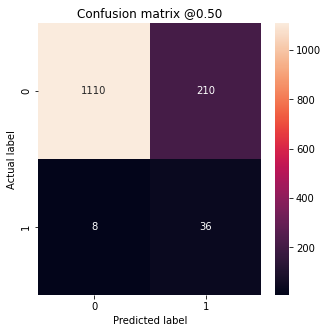

In [ ]:
results = model.evaluate(test_features, test_labels,
                                           batch_size=64, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions)

#### Method 1: Naive Data Augmentation

In [ ]:
# Build the model with the best hyperparameters
model_oversampler = tuner_oversampler.hypermodel.build(best_hps_oversampler)

# Train the model with the best hyperparameters
history_oversampler = model_oversampler.fit(train_features_oversampler, train_labels_oversampler, validation_data=(val_features, val_labels), epochs=200) #batch_size=64)

Epoch 1/200
231/231 [==============================] - 5s 8ms/step - loss: 1.5456 - tp: 2893.0000 - fp: 1072.0000 - tn: 3943.0000 - fn: 846.0000 - accuracy: 0.7809 - precision: 0.7296 - f1_score: 0.7510 - val_loss: 0.5853 - val_tp: 46.0000 - val_fp: 300.0000 - val_tn: 1284.0000 - val_fn: 7.0000 - val_accuracy: 0.8125 - val_precision: 0.1329 - val_f1_score: 0.2306
Epoch 2/200
231/231 [==============================] - 1s 6ms/step - loss: 0.5142 - tp: 3171.0000 - fp: 637.0000 - tn: 3058.0000 - fn: 524.0000 - accuracy: 0.8429 - precision: 0.8327 - f1_score: 0.8453 - val_loss: 0.4039 - val_tp: 43.0000 - val_fp: 193.0000 - val_tn: 1391.0000 - val_fn: 10.0000 - val_accuracy: 0.8760 - val_precision: 0.1822 - val_f1_score: 0.2976
Epoch 3/200
231/231 [==============================] - 2s 8ms/step - loss: 0.4723 - tp: 3188.0000 - fp: 582.0000 - tn: 3113.0000 - fn: 507.0000 - accuracy: 0.8526 - precision: 0.8456 - f1_score: 0.8541 - val_loss: 0.5377 - val_tp: 46.0000 - val_fp: 307.0000 - val_tn: 

In [ ]:
val_predictions_oversampler = model_oversampler.predict(val_features, batch_size=64)
test_predictions_oversampler = model_oversampler.predict(test_features, batch_size=64)

22/22 [==============================] - 0s 2ms/step


loss :  0.36364367604255676
tp :  34.0
fp :  179.0
tn :  1141.0
fn :  10.0
accuracy :  0.8614369630813599
precision :  0.15962441265583038
f1_score :  [0.26459146]

True Negatives:  1141
False Positives: net and Type I percent error 179 0.13560606060606062
False Negatives: net and Type II percent error 10 0.22727272727272727
True Positives: 34
Total Bankruptcies:  44


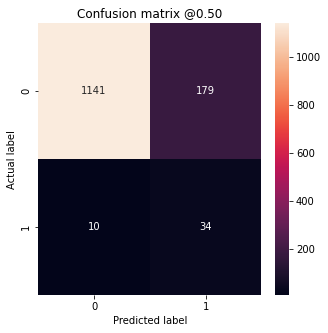

In [ ]:
results_oversampler = model_oversampler.evaluate(test_features, test_labels,
                                           batch_size=64, verbose=0)
for name, value in zip(model_oversampler.metrics_names, results_oversampler):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_oversampler)

#### Method 2: SMOTE (Synthetic Over-Sampling)

In [ ]:
# Build the model with the best hyperparameters
model_smote = tuner_smote.hypermodel.build(best_hps_smote)

# Train the model with the best hyperparameters
history_smote = model_smote.fit(train_features_smote, train_labels_smote, validation_data=(val_features, val_labels), epochs=150) #batch_size=64)

Epoch 1/150
231/231 [==============================] - 4s 8ms/step - loss: 1.1341 - tp: 2967.0000 - fp: 1021.0000 - tn: 4258.0000 - fn: 781.0000 - accuracy: 0.8004 - precision: 0.7440 - f1_score: 0.7671 - val_loss: 0.4098 - val_tp: 42.0000 - val_fp: 177.0000 - val_tn: 1407.0000 - val_fn: 11.0000 - val_accuracy: 0.8852 - val_precision: 0.1918 - val_f1_score: 0.3088
Epoch 2/150
231/231 [==============================] - 1s 6ms/step - loss: 0.4658 - tp: 3274.0000 - fp: 587.0000 - tn: 3108.0000 - fn: 421.0000 - accuracy: 0.8636 - precision: 0.8480 - f1_score: 0.8666 - val_loss: 0.4390 - val_tp: 44.0000 - val_fp: 226.0000 - val_tn: 1358.0000 - val_fn: 9.0000 - val_accuracy: 0.8564 - val_precision: 0.1630 - val_f1_score: 0.2724
Epoch 3/150
231/231 [==============================] - 2s 7ms/step - loss: 0.4344 - tp: 3271.0000 - fp: 578.0000 - tn: 3117.0000 - fn: 424.0000 - accuracy: 0.8644 - precision: 0.8498 - f1_score: 0.8672 - val_loss: 0.4559 - val_tp: 45.0000 - val_fp: 252.0000 - val_tn: 

In [ ]:
train_predictions_smote = model_smote.predict(train_features_smote, batch_size=64)
val_predictions_smote = model_smote.predict(val_features, batch_size=64)
test_predictions_smote = model_smote.predict(test_features, batch_size=64)

22/22 [==============================] - 0s 2ms/step


loss :  0.24496157467365265
tp :  29.0
fp :  101.0
tn :  1219.0
fn :  15.0
accuracy :  0.9149560332298279
precision :  0.2230769246816635
f1_score :  [0.33333334]

True Negatives:  1219
False Positives: net and Type I percent error 101 0.07651515151515151
False Negatives: net and Type II percent error 15 0.3409090909090909
True Positives: 29
Total Bankruptcies:  44


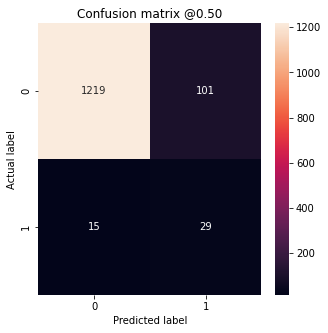

In [ ]:
results_smote = model_smote.evaluate(test_features, test_labels,
                                           batch_size=64, verbose=0)
for name, value in zip(model_smote.metrics_names, results_smote):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_smote)

# Feature Importance for Baseline Model



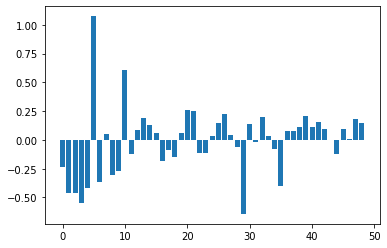

Most important features: [ 5 29 10  3  1  2  4 35  6  8]


In [ ]:
# define a function to compute the gradient of the model output with respect to the input features
def get_gradients(model, features):
    with tf.GradientTape() as tape:
        tape.watch(features)
        predictions = model(features)
    gradients = tape.gradient(predictions, features)
    return tf.reduce_mean(gradients, axis=0)

# compute the gradients using the trained model and the validation features
train_features_tensor = tf.convert_to_tensor(train_features)
gradients = get_gradients(model, train_features_tensor)

# get the indices of the most important features
sorted_indices = np.argsort(np.abs(gradients))[::-1]

# plot the magnitudes of the gradients as a bar chart to visualize the feature importances
import matplotlib.pyplot as plt
plt.bar(range(len(gradients.numpy())), gradients.numpy())
plt.show()

# print the indices of the most important features
print("Most important features:", sorted_indices[:10])



In [ ]:
sorted_indices = [5,29,10,3,1,2,4,35,6,8,9,20,21,0,26,39,32,13,47,16,41,18,48,25,30,14,44,11,23,40,22,38,42,45,17,12,34,37,36,15,28,19,7,27,24,33,31,46,43]

print(sorted_indices)

[5, 29, 10, 3, 1, 2, 4, 35, 6, 8, 9, 20, 21, 0, 26, 39, 32, 13, 47, 16, 41, 18, 48, 25, 30, 14, 44, 11, 23, 40, 22, 38, 42, 45, 17, 12, 34, 37, 36, 15, 28, 19, 7, 27, 24, 33, 31, 46, 43]


In [ ]:
# most important features for naive model

important_features = [corr_df.index[i] for i in sorted_indices]

for item in important_features:
  print(item)

 Debt ratio %
 Cash/Total Assets
 Current Liability to Assets
 ROA(C) before interest and depreciation before interest
 ROA(A) before interest and % after tax
 ROA(B) before interest and depreciation after tax
 Net worth/Assets
 Equity to Liability
 Persistent EPS in the Last Four Seasons
 Net profit before tax/Paid-in capital
 Per Share Net profit before tax (Yuan ¥)
 Current Liabilities/Equity
 Working Capital/Equity
 Net Income to Total Assets
 Equity to Long-term Liability
 Inventory and accounts receivable/Net value
 Realized Sales Gross Margin
 Borrowing dependency
 Cash Flow to Equity
 Net Value Per Share (A)
 Cash flow rate
 Net Value Per Share (C)
 Cash Reinvestment %
 Total expense/Assets
 Gross Profit to Sales
 Current Liability to Current Assets
 Total Asset Turnover
 Working Capital to Total Assets
 Operating profit/Paid-in capital
 Fixed Assets Turnover Frequency
 Operating Profit Per Share (Yuan ¥)
 Operating Funds to Liability
 Cash Flow to Total Assets
 Fixed Assets to

# Feature Importance for Naive Data Augmentation Model



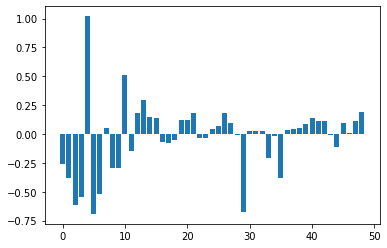

Most important features: [ 4  5 29  2  3  6 10  1 35 13]


In [ ]:
# define a function to compute the gradient of the model output with respect to the input features
def get_gradients(model, features):
    with tf.GradientTape() as tape:
        tape.watch(features)
        predictions = model(features)
    gradients = tape.gradient(predictions, features)
    return tf.reduce_mean(gradients, axis=0)

# compute the gradients using the trained model and the validation features
train_features_oversampler_tensor = tf.convert_to_tensor(train_features_oversampler)
gradients_oversampler = get_gradients(model_oversampler, train_features_oversampler_tensor)

# get the indices of the most important features
sorted_indices_oversampler = np.argsort(np.abs(gradients_oversampler))[::-1]

# plot the magnitudes of the gradients as a bar chart to visualize the feature importances
import matplotlib.pyplot as plt
plt.bar(range(len(gradients_oversampler.numpy())), gradients_oversampler.numpy())
plt.show()

# print the indices of the most important features
print("Most important features:", sorted_indices_oversampler[:10])



In [ ]:
sorted_indices_oversampler = [4, 5, 29, 2, 3, 6, 10, 1, 35, 13, 9, 8, 0, 33, 48, 12, 26, 21, 11, 14, 40, 15, 19, 20, 41, 42, 47, 44, 27, 45, 39, 17, 16, 25, 38, 7, 18, 37, 24, 36, 22, 23, 31, 32, 30, 34, 46, 43, 28]

print(sorted_indices_oversampler)

[4, 5, 29, 2, 3, 6, 10, 1, 35, 13, 9, 8, 0, 33, 48, 12, 26, 21, 11, 14, 40, 15, 19, 20, 41, 42, 47, 44, 27, 45, 39, 17, 16, 25, 38, 7, 18, 37, 24, 36, 22, 23, 31, 32, 30, 34, 46, 43, 28]


In [ ]:
# most important features for naive model

oversampler_important_features = [corr_df.index[i] for i in sorted_indices_oversampler]

for item in oversampler_important_features:
  print(item)

 Net worth/Assets
 Debt ratio %
 Cash/Total Assets
 ROA(B) before interest and depreciation after tax
 ROA(C) before interest and depreciation before interest
 Persistent EPS in the Last Four Seasons
 Current Liability to Assets
 ROA(A) before interest and % after tax
 Equity to Liability
 Borrowing dependency
 Per Share Net profit before tax (Yuan ¥)
 Net profit before tax/Paid-in capital
 Net Income to Total Assets
 Operating profit per person
 Cash Reinvestment %
 Net Income to Stockholder's Equity
 Equity to Long-term Liability
 Working Capital/Equity
 Working Capital to Total Assets
 Current Liability to Current Assets
 Fixed Assets Turnover Frequency
 Liability to Equity
 Current Liability to Equity
 Current Liabilities/Equity
 Cash flow rate
 Cash Flow to Total Assets
 Cash Flow to Equity
 Total Asset Turnover
 CFO to Assets
 Fixed Assets to Assets
 Inventory and accounts receivable/Net value
 Net Value Per Share (B)
 Net Value Per Share (A)
 Total expense/Assets
 Operating Fund

# Feature Importance for SMOTE Model



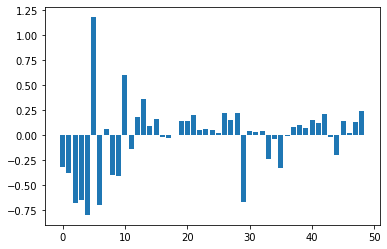

Most important features: [ 5  4  6  2 29  3 10  9  8  1]


In [ ]:
# define a function to compute the gradient of the model output with respect to the input features
def get_gradients(model, features):
    with tf.GradientTape() as tape:
        tape.watch(features)
        predictions = model(features)
    gradients = tape.gradient(predictions, features)
    return tf.reduce_mean(gradients, axis=0)

# compute the gradients using the trained model and the validation features
train_features_smote_tensor = tf.convert_to_tensor(train_features_smote)
gradients = get_gradients(model_smote, train_features_smote_tensor)

# get the indices of the most important features
sorted_indices_smote = np.argsort(np.abs(gradients))[::-1]

# plot the magnitudes of the gradients as a bar chart to visualize the feature importances
import matplotlib.pyplot as plt
plt.bar(range(len(gradients.numpy())), gradients.numpy())
plt.show()

# print the indices of the most important features
print("Most important features:", sorted_indices_smote[:10])



In [ ]:
sorted_indices_smote= [5, 4, 6, 2, 29, 3, 10, 9, 8, 1, 13, 35, 0, 48, 33, 26, 28, 42, 21, 44, 12, 15, 40, 27, 11, 19, 20, 45, 47, 41, 38, 14, 37, 39, 23, 7, 22, 24, 30, 34, 32, 31, 17, 16, 25, 43, 46, 36, 18]

print(sorted_indices_smote)

[5, 4, 6, 2, 29, 3, 10, 9, 8, 1, 13, 35, 0, 48, 33, 26, 28, 42, 21, 44, 12, 15, 40, 27, 11, 19, 20, 45, 47, 41, 38, 14, 37, 39, 23, 7, 22, 24, 30, 34, 32, 31, 17, 16, 25, 43, 46, 36, 18]


In [ ]:
# most important features for SMOTE model

smote_important_features = [corr_df.index[i] for i in sorted_indices_smote]

for item in smote_important_features:
  print(item)

 Debt ratio %
 Net worth/Assets
 Persistent EPS in the Last Four Seasons
 ROA(B) before interest and depreciation after tax
 Cash/Total Assets
 ROA(C) before interest and depreciation before interest
 Current Liability to Assets
 Per Share Net profit before tax (Yuan ¥)
 Net profit before tax/Paid-in capital
 ROA(A) before interest and % after tax
 Borrowing dependency
 Equity to Liability
 Net Income to Total Assets
 Cash Reinvestment %
 Operating profit per person
 Equity to Long-term Liability
 Tax rate (A)
 Cash Flow to Total Assets
 Working Capital/Equity
 Total Asset Turnover
 Net Income to Stockholder's Equity
 Liability to Equity
 Fixed Assets Turnover Frequency
 CFO to Assets
 Working Capital to Total Assets
 Current Liability to Equity
 Current Liabilities/Equity
 Fixed Assets to Assets
 Cash Flow to Equity
 Cash flow rate
 Operating Funds to Liability
 Current Liability to Current Assets
 Cash Flow Per Share
 Inventory and accounts receivable/Net value
 Operating profit/Paid

Top 5 Most Important Features Appearing Among All 3 Models

In [ ]:
# Find the common elements in the three lists
common_features = set(important_features)

# Sort the common features by their index in the smote_important_features list
sorted_common_features = sorted(common_features, key=lambda x: smote_important_features.index(x))

# Take the first 5 elements
top_5_common_features = sorted_common_features[:5]

print(top_5_common_features)

[' Debt ratio %', ' Net worth/Assets', ' Persistent EPS in the Last Four Seasons', ' ROA(B) before interest and depreciation after tax', ' Cash/Total Assets']
